# Data preprocessing

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
!pip install gensim

     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.6 kB ? eta -:--:--
     ------------------------- ------------ 41.0/60.6 kB 495.5 kB/s eta 0:00:01
     -------------------------------------- 60.6/60.6 kB 645.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   - -------------------------------------- 0.8/24.0 MB 16.8 MB/s eta 0:00:02
   -- ------------------------------------- 1.7/24.0 MB 21.9 MB/s eta 0:00:02
   ---- ----------------------------------- 2.4/24.0 MB 17.0 MB/s eta 0:00:02
   ----- ---------------------------------- 3.2/24.0 MB 17.0 MB/s eta 0:00:02
   ------ --------------------------------- 4.2/24.0 MB 17.9 MB/s eta 0:00:02
   --------- ------------------------------ 5.9/24.0 MB 20.8 MB/s eta 0:00:01
   ------------- -------------------------- 7.9/24.0 MB 24.1 MB/s eta 0:00:01
   ---------------- ----------------------- 9.6/24.0 MB 25.7 MB/s eta 0:00:01
 


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from gensim.models import word2vec

In [3]:
current_directory = os.getcwd()
print(current_directory)

c:\Users\seowoo kim\Desktop\노나없


In [4]:
# Japan first_read japan data
data_j = pd.read_csv("./intern_review_japan_only_sentences.csv")
data_j.head()

,SeparatedSentences
0,I think I've seen it six times.It's kind of li...
1,Is it because of the taxi driver's movie that ...
2,It's a very good movie that warms your heart a...
3,"After I finished watching it, I was filled wit..."
4,The story is about friendship across generatio...


# Preprocessing Strategy

1. Expand contractions : pycontractions
2. lowercase
3. change numbers to words : inflect
4. Remove Punctuations : '!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'
5. Remove remained emoji, japanese, chinese, korean words
6. PoS_tagging: from nltk import pos_tag
7. If needed, remove PRP, TO, DT, etc. 
8. Stemming: PorterStemmer
9. Find out average sentence length
10. Wordcloud


In [5]:
# Pycontractions doesn't work due to dependency issue. I just modulized it by myself.

from contractions import expand_contractions

contracted_list = []
Sentences = data_j['SeparatedSentences'].copy()

for sentence in Sentences:
    expanded_sentence = expand_contractions(sentence)
    contracted_list.append(expanded_sentence)


In [6]:
contracted_list[:5]

['I think i have seen it six times.it is kind of like playing the role of a good grandpa gentleman (^^) who does not seem to be De Niro who played scary roles such as Alpacino.',
 "Is it because of the taxi driver's movie that i am going to be a driver?",
 'it is a very good movie that warms your heart and motivates you!',
 'After I finished watching it, I was filled with happiness.All the characters are attractive and live their lives with all their might.I also want to improve my work and private life from tomorrow.It was a good movie.',
 'The story is about friendship across generations.Retired gentleman Ben will join a new apparel manufacturer led by Jules of Barricari as an intern.Ben is the ideal combination of wanting to be such an old gentleman.it is refreshing even after watching it, and I recommend it when you want to feel positive.']

In [7]:
# Transform all sentences into lower case! easy!

contracted_list = [text.lower() for text in contracted_list]

In [8]:
contracted_list[:5]

['i think i have seen it six times.it is kind of like playing the role of a good grandpa gentleman (^^) who does not seem to be de niro who played scary roles such as alpacino.',
 "is it because of the taxi driver's movie that i am going to be a driver?",
 'it is a very good movie that warms your heart and motivates you!',
 'after i finished watching it, i was filled with happiness.all the characters are attractive and live their lives with all their might.i also want to improve my work and private life from tomorrow.it was a good movie.',
 'the story is about friendship across generations.retired gentleman ben will join a new apparel manufacturer led by jules of barricari as an intern.ben is the ideal combination of wanting to be such an old gentleman.it is refreshing even after watching it, and i recommend it when you want to feel positive.']

In [14]:
! pip install inflect

   ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
   ---------------------------------------- 60.9/60.9 kB 3.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# Change numbers into words
import inflect
p = inflect.engine()

def convert_number(text):
    def replace_number(match):
        number = match.group()
        return p.number_to_words(number)
    
    converted_text = re.sub(r'\d+', replace_number, text)
    return converted_text

inflected_list = []
inflected_list = [convert_number(text) for text in contracted_list]         

In [10]:
# Remove punctuations
rm_punctionations = inflected_list.copy()

def rm_punct(text):
    cleaned_text = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]', ' ', text)
    return cleaned_text

rm_punctionations = [rm_punct(text) for text in rm_punctionations]

In [11]:
rm_punctionations

['i think i have seen it six times it is kind of like playing the role of a good grandpa gentleman      who does not seem to be de niro who played scary roles such as alpacino ',
 'is it because of the taxi driver s movie that i am going to be a driver ',
 'it is a very good movie that warms your heart and motivates you ',
 'after i finished watching it  i was filled with happiness all the characters are attractive and live their lives with all their might i also want to improve my work and private life from tomorrow it was a good movie ',
 'the story is about friendship across generations retired gentleman ben will join a new apparel manufacturer led by jules of barricari as an intern ben is the ideal combination of wanting to be such an old gentleman it is refreshing even after watching it  and i recommend it when you want to feel positive ',
 'i honestly thought that this would be all right for the heartful series ',
 'the story is about a woman who has a family and is working hard 

In [12]:
# remove japanese, korean, chinese words

def only_english(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return cleaned_text

rm_punctionations = [only_english(text) for text in rm_punctionations]

In [13]:
# POS_tagging

import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# 필요한 NLTK 데이터 다운로드
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Text를 단어 토큰과 POS 태그로 변환
def pos_tagging(text):
    word_tokens = word_tokenize(text)
    return pos_tag(word_tokens)

tag_sentence = rm_punctionations.copy()

tag_sentence = [pos_tagging(text) for text in tag_sentence]


[nltk_data] Downloading package punkt to C:\Users\seowoo
[nltk_data]     kim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\seowoo kim\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [14]:
tag_sentence

[[('i', 'JJ'),
  ('think', 'VBP'),
  ('i', 'NNS'),
  ('have', 'VBP'),
  ('seen', 'VBN'),
  ('it', 'PRP'),
  ('six', 'CD'),
  ('times', 'NNS'),
  ('it', 'PRP'),
  ('is', 'VBZ'),
  ('kind', 'NN'),
  ('of', 'IN'),
  ('like', 'IN'),
  ('playing', 'VBG'),
  ('the', 'DT'),
  ('role', 'NN'),
  ('of', 'IN'),
  ('a', 'DT'),
  ('good', 'JJ'),
  ('grandpa', 'NN'),
  ('gentleman', 'NN'),
  ('who', 'WP'),
  ('does', 'VBZ'),
  ('not', 'RB'),
  ('seem', 'VB'),
  ('to', 'TO'),
  ('be', 'VB'),
  ('de', 'VBN'),
  ('niro', 'FW'),
  ('who', 'WP'),
  ('played', 'VBD'),
  ('scary', 'JJ'),
  ('roles', 'NNS'),
  ('such', 'JJ'),
  ('as', 'IN'),
  ('alpacino', 'NN')],
 [('is', 'VBZ'),
  ('it', 'PRP'),
  ('because', 'IN'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('taxi', 'NN'),
  ('driver', 'NN'),
  ('s', 'VBD'),
  ('movie', 'NN'),
  ('that', 'IN'),
  ('i', 'NN'),
  ('am', 'VBP'),
  ('going', 'VBG'),
  ('to', 'TO'),
  ('be', 'VB'),
  ('a', 'DT'),
  ('driver', 'NN')],
 [('it', 'PRP'),
  ('is', 'VBZ'),
  ('a', 'DT'),
 

In [15]:
#nltk.download('tagsets')
#nltk.help.upenn_tagset('WP')

In [16]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Remove IN, PRP, CC, PRP$, DT, TO, FW, WP
def remove_specific_tags(tagged_sentence, tags_to_remove):
    return [word for word, tag in tagged_sentence if tag not in tags_to_remove]

tags_to_remove = {"IN", "PRP", "CC", "PRP$", "DT", "TO", "FW", "WP"}

tag_rm = tag_sentence.copy()
tag_rm = [remove_specific_tags(text, tags_to_remove) for text in tag_rm]

In [17]:
tag_rm_sentence = [pos_tag(sentence) for sentence in tag_rm]
tag_rm_sentence[:5]

[[('i', 'JJ'),
  ('think', 'VBP'),
  ('i', 'NNS'),
  ('have', 'VBP'),
  ('seen', 'VBN'),
  ('six', 'CD'),
  ('times', 'NNS'),
  ('is', 'VBZ'),
  ('kind', 'NN'),
  ('playing', 'VBG'),
  ('role', 'NN'),
  ('good', 'JJ'),
  ('grandpa', 'NN'),
  ('gentleman', 'NN'),
  ('does', 'VBZ'),
  ('not', 'RB'),
  ('seem', 'VB'),
  ('be', 'VB'),
  ('de', 'FW'),
  ('played', 'FW'),
  ('scary', 'JJ'),
  ('roles', 'NNS'),
  ('such', 'JJ'),
  ('alpacino', 'NN')],
 [('is', 'VBZ'),
  ('taxi', 'JJ'),
  ('driver', 'RB'),
  ('s', 'JJ'),
  ('movie', 'NN'),
  ('i', 'NN'),
  ('am', 'VBP'),
  ('going', 'VBG'),
  ('be', 'VB'),
  ('driver', 'RB')],
 [('is', 'VBZ'),
  ('very', 'RB'),
  ('good', 'JJ'),
  ('movie', 'NN'),
  ('warms', 'NNS'),
  ('heart', 'NN'),
  ('motivates', 'NNS')],
 [('i', 'NN'),
  ('finished', 'VBD'),
  ('watching', 'VBG'),
  ('i', 'NN'),
  ('was', 'VBD'),
  ('filled', 'VBN'),
  ('happiness', 'RB'),
  ('all', 'DT'),
  ('characters', 'NNS'),
  ('are', 'VBP'),
  ('attractive', 'JJ'),
  ('live', 'JJ'

In [18]:
# Lemmatize & remove stopwords

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import wordnet as wn

nltk.download('wordnet')

# inflect engine initialize
p = inflect.engine()

# WordNetLemmatizer initialize
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return None

def singularize_and_lemmatize(tagged_words):
    new_words = []
    
    for word, tag in tagged_words:
        if tag.startswith('N'):
            singular_word = p.singular_noun(word)
            if singular_word:
                new_words.append(singular_word)
            else:
                new_words.append(word)
        else:
            wn_tag = get_wordnet_pos(tag)
            if wn_tag is not None:
                lemma_word = lemmatizer.lemmatize(word, wn_tag)
                new_words.append(lemma_word)
            else:
                new_words.append(word)
    
    return new_words

[nltk_data] Downloading package wordnet to C:\Users\seowoo
[nltk_data]     kim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
processed_sentences = [singularize_and_lemmatize(sentence) for sentence in tag_rm_sentence]

In [20]:
processed_sentences

[['i',
  'think',
  'i',
  'have',
  'see',
  'six',
  'time',
  'be',
  'kind',
  'play',
  'role',
  'good',
  'grandpa',
  'gentleman',
  'do',
  'not',
  'seem',
  'be',
  'de',
  'played',
  'scary',
  'role',
  'such',
  'alpacino'],
 ['be', 'taxi', 'driver', 's', 'movie', 'i', 'be', 'go', 'be', 'driver'],
 ['be', 'very', 'good', 'movie', 'warm', 'heart', 'motivate'],
 ['i',
  'finish',
  'watch',
  'i',
  'be',
  'fill',
  'happiness',
  'all',
  'character',
  'be',
  'attractive',
  'live',
  'life',
  'might',
  'i',
  'also',
  'want',
  'improve',
  'work',
  'private',
  'life',
  'tomorrow',
  'be',
  'good',
  'movie'],
 ['story',
  'be',
  'friendship',
  'generation',
  'retire',
  'gentleman',
  'ben',
  'will',
  'join',
  'new',
  'apparel',
  'manufacturer',
  'lead',
  'jule',
  'barricari',
  'intern',
  'ben',
  'be',
  'ideal',
  'combination',
  'want',
  'be',
  'such',
  'old',
  'gentleman',
  'be',
  'refresh',
  'even',
  'watch',
  'i',
  'recommend',
  

In [21]:
# stopwords
def remove_verbs(words):
    verbs_to_remove = {"am", "be", "are", "was", "were", "being", "is"}
    filtered_words = [word for word in words if word not in verbs_to_remove]
    return filtered_words

processed_sentences_no_stopwords = [remove_verbs(word) for word in processed_sentences]

In [22]:
processed_sentences_no_stopwords

[['i',
  'think',
  'i',
  'have',
  'see',
  'six',
  'time',
  'kind',
  'play',
  'role',
  'good',
  'grandpa',
  'gentleman',
  'do',
  'not',
  'seem',
  'de',
  'played',
  'scary',
  'role',
  'such',
  'alpacino'],
 ['taxi', 'driver', 's', 'movie', 'i', 'go', 'driver'],
 ['very', 'good', 'movie', 'warm', 'heart', 'motivate'],
 ['i',
  'finish',
  'watch',
  'i',
  'fill',
  'happiness',
  'all',
  'character',
  'attractive',
  'live',
  'life',
  'might',
  'i',
  'also',
  'want',
  'improve',
  'work',
  'private',
  'life',
  'tomorrow',
  'good',
  'movie'],
 ['story',
  'friendship',
  'generation',
  'retire',
  'gentleman',
  'ben',
  'will',
  'join',
  'new',
  'apparel',
  'manufacturer',
  'lead',
  'jule',
  'barricari',
  'intern',
  'ben',
  'ideal',
  'combination',
  'want',
  'such',
  'old',
  'gentleman',
  'refresh',
  'even',
  'watch',
  'i',
  'recommend',
  'when',
  'want',
  'feel',
  'positive'],
 ['i', 'honestly', 'think', 'would', 'right', 'heartf

In [23]:
# final..refine!

def replace_words(sentence):
    replacements = {
        r'\binternben\b': ['intern', 'ben'],
        r'\bexperiencesben\b': ['experience', 'ben'],
        r'\bbeingben\b': ['being', 'ben'],
        r'\bbentwo\b': ['ben', 'two'],
        r'\bbens\b': ['ben'],
        r'\bitben\b': ['it', 'ben'],
        r'\bheartben\b': ['heart', 'ben'],
        r'\botherben\b': ['other', 'ben'],
        r'\bbentheir\b': ['ben', 'their'],
        r'\bfamilyben\b': ['family', 'ben'],
        r'\bfunben\b': ['fun', 'ben'],
        r'\binternrobert\b': ['intern', 'robert'],
        r'\buprobert\b': ['up', 'robert'],
        r'\brealisticrobert\b': ['realistic', 'robert'],
        r'\btemperrobert\b': ['temper', 'robert'],
        r'\bplacerobert\b': ['place', 'robert'],
        r'\btimesrobert\b': ['time', 'robert'],
        r'\bniros\b': ['niro'],
        r'\bdeniro\b': ['niro'],
        r'\bniroi\b': ['niro', 'I'],
        r'\bmyershe\b': ['she'],
        r'\bmyersworking\b': ['working'],
        r'\banhathaway\b': ['hathaway'],
        r'\bsceneanhathaway\b': ['scene', 'hathaway'],
        r'\banhathawayhis\b': ['hathaway', 'his'],
        r'\bhathawayde\b': ['hathaway', 'de'],
        r'\bhathaways\b': ['hathaway'],
        r'\banhathaways\b': ['hathaway'],
        r'\brottenanhathaway\b': ['rotten', 'hathaway'],
        r'\btherejules\b': ['there', 'jule'],
        r'\bweakjule\b': ['weak', 'jule'],
        r'\bjules\b': ['jule'],
        r'\broutinejule\b': ['routine', 'jule'],
        r'\bagejule\b': ['age', 'jule'],
    }
    for pattern, replacement in replacements.items():
        sentence = re.sub(pattern, ' '.join(replacement), sentence)

    return sentence.split()

modified_sentences = [replace_words(' '.join(sentence)) for sentence in processed_sentences_no_stopwords]

In [24]:
modified_sentences

[['i',
  'think',
  'i',
  'have',
  'see',
  'six',
  'time',
  'kind',
  'play',
  'role',
  'good',
  'grandpa',
  'gentleman',
  'do',
  'not',
  'seem',
  'de',
  'played',
  'scary',
  'role',
  'such',
  'alpacino'],
 ['taxi', 'driver', 's', 'movie', 'i', 'go', 'driver'],
 ['very', 'good', 'movie', 'warm', 'heart', 'motivate'],
 ['i',
  'finish',
  'watch',
  'i',
  'fill',
  'happiness',
  'all',
  'character',
  'attractive',
  'live',
  'life',
  'might',
  'i',
  'also',
  'want',
  'improve',
  'work',
  'private',
  'life',
  'tomorrow',
  'good',
  'movie'],
 ['story',
  'friendship',
  'generation',
  'retire',
  'gentleman',
  'ben',
  'will',
  'join',
  'new',
  'apparel',
  'manufacturer',
  'lead',
  'jule',
  'barricari',
  'intern',
  'ben',
  'ideal',
  'combination',
  'want',
  'such',
  'old',
  'gentleman',
  'refresh',
  'even',
  'watch',
  'i',
  'recommend',
  'when',
  'want',
  'feel',
  'positive'],
 ['i', 'honestly', 'think', 'would', 'right', 'heartf

In [25]:
# remove empty list
modified_sentences = [sentence for sentence in modified_sentences if sentence]

In [26]:
lengths = [len(sentence) for sentence in modified_sentences]

# sentence lenths discriptive analysis
median = np.median(lengths)
mean = np.mean(lengths)
percentile_75 = np.percentile(lengths, 75)
percentile_90 = np.percentile(lengths, 90)
percentile_95 = np.percentile(lengths, 95)

print ('median: ', median, 
       'mean: ', mean, 
       'per_75: ', percentile_75, 
       'per_90: ', percentile_90, 
       'per_95: ', percentile_95)

median:  9.0 mean:  11.677235948388546 per_75:  15.0 per_90:  23.0 per_95:  31.0


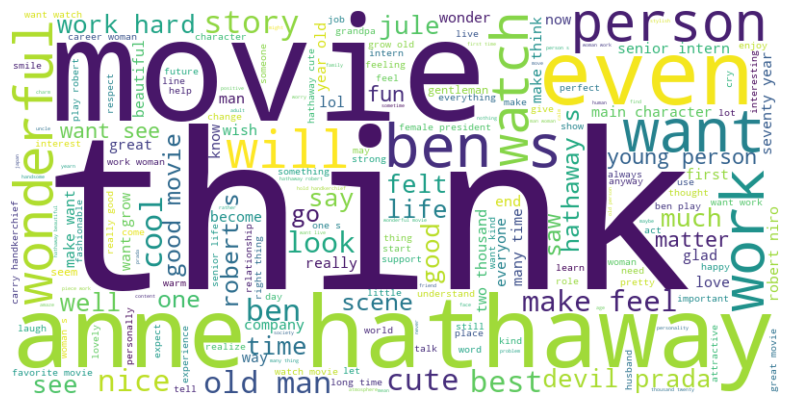

In [27]:
#wordcloud
from wordcloud import WordCloud
text_data_japan = " ".join([" ".join(sentence) for sentence in modified_sentences])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data_japan)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [29]:
from collections import Counter
all_words = [word for sentence in modified_sentences for word in sentence]
word_freq= Counter(all_words)
print(word_freq)

Counter({'i': 108283, 'not': 25721, 'movie': 25361, 'work': 23591, 'have': 23173, 'want': 21233, 'do': 20257, 's': 18759, 'ben': 18672, 'good': 18094, 'person': 17492, 'think': 16825, 'hathaway': 15249, 'robert': 13436, 'old': 13368, 'can': 13034, 'watch': 12493, 'that': 12452, 'so': 12053, 'make': 11200, 'see': 10121, 'when': 9644, 'there': 9376, 'time': 9312, 'life': 9162, 'woman': 8957, 'feel': 8516, 'man': 8098, 'too': 8069, 'very': 7964, 'wonderful': 7782, 'jule': 6950, 'get': 6824, 'story': 6769, 'really': 6698, 'cute': 6579, 'will': 6485, 'also': 6386, 'would': 6284, 'love': 6000, 'cool': 5962, 'thing': 5949, 'one': 5800, 'intern': 5467, 'other': 5400, 'anne': 5394, 'such': 5309, 'even': 5134, 'best': 5128, 'look': 5127, 'could': 5126, 'company': 5010, 'nice': 5007, 'age': 5005, 'go': 4984, 'handkerchief': 4906, 'hard': 4773, 'many': 4766, 'up': 4736, 'gentleman': 4716, 'way': 4679, 'how': 4664, 'two': 4643, 'young': 4534, 'character': 4497, 'kind': 4420, 'more': 4331, 'play': 4

In [30]:
df_word_freq = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
df_word_freq.sort_values(by='Frequency', ascending=False, inplace=True)
df_word_freq

,Word,Frequency
0,i,108283
13,not,25721
23,movie,25361
42,work,23591
2,have,23173
...,...,...
9391,adjusting,1
9389,rable,1
9387,stew,1
3336,willednes,1


In [31]:
! pip install openpyxl
df_word_freq.to_excel('word_freq_japan.xlsx')


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# word2Vec

In [32]:
from gensim.models import Word2Vec

In [33]:
model = Word2Vec(sentences=modified_sentences, vector_size=100, window=23, min_count=2, workers=1)

In [34]:
model.save("word2vec_japan.model")

In [35]:
word_vectors = model.wv

In [36]:
similar_words = word_vectors.most_similar('intern')
print(similar_words)

[('internship', 0.8203942775726318), ('citizen', 0.7493717074394226), ('hire', 0.669509768486023), ('program', 0.6686146259307861), ('system', 0.6638776063919067), ('employ', 0.6492123603820801), ('apply', 0.6468455791473389), ('newcomer', 0.6351824998855591), ('initially', 0.6213891506195068), ('apparel', 0.6159231662750244)]


In [37]:
similar_words_100 = word_vectors.most_similar('age', topn=100)
print("Top 100 similar words:", similar_words_100)


Top 100 similar words: [('generation', 0.611061155796051), ('generational', 0.6044162511825562), ('value', 0.5800896286964417), ('superior', 0.568016529083252), ('gender', 0.5526430606842041), ('humbly', 0.5161969661712646), ('respect', 0.5030502676963806), ('prejudice', 0.4943404495716095), ('year', 0.48645225167274475), ('culture', 0.4757722020149231), ('actively', 0.4745637774467468), ('field', 0.4646584689617157), ('taught', 0.4629107415676117), ('form', 0.46139198541641235), ('sex', 0.4531290531158447), ('status', 0.4460809528827667), ('elder', 0.4427943527698517), ('hospitality', 0.44024458527565), ('equal', 0.43957453966140747), ('transmit', 0.4391789436340332), ('develop', 0.4366220533847809), ('position', 0.4355429410934448), ('knowledge', 0.4352964162826538), ('treat', 0.4336062967777252), ('youth', 0.4317227005958557), ('wisdom', 0.4313386082649231), ('vision', 0.4255888760089874), ('decline', 0.424468994140625), ('ambitious', 0.4235786497592926), ('bear', 0.4216061234474182